In [64]:
# ! pip install lifelines
# ! pip install Matplotlib
# ! pip install numpy
# ! pip install pandas
# ! pip install seaborn


In [65]:
# Load libraries
import shutil
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType,StructField,DoubleType, StringType, IntegerType, DateType, TimestampType


In [66]:
# Set config for database name, file paths, and table names
import getpass

user = getpass.getuser()  # Get the current username
username_sql = user.replace(".", "_")
database_name = f'dm_ibm_telco_churn_{username_sql}'
data_path = '/{}/ibm-telco-churn'.format(user) 
driver_to_dbfs_path = '{}/Telco-Customer-Churn.csv'.format(data_path) 
bronze_tbl_path = '{}/bronze/'.format(data_path) 
silver_tbl_path = '{}/silver/'.format(data_path) 
 
bronze_tbl_name = 'bronze_customers'
silver_tbl_name = 'silver_monthly_customers'

In [67]:
# 导入所需的库
from pyspark.sql import SparkSession

# 创建或获取 SparkSession
spark = SparkSession.builder \
    .appName("TelcoDataDeltaLake") \
    .config("spark.sql.catalog.spark_catalog.type", "hive") \
    .getOrCreate()



In [68]:


# Define schema
schema = StructType([
  StructField('customerID', StringType()),
  StructField('gender', StringType()),
  StructField('seniorCitizen', DoubleType()),
  StructField('partner', StringType()),
  StructField('dependents', StringType()),
  StructField('tenure', DoubleType()),
  StructField('phoneService', StringType()),
  StructField('multipleLines', StringType()),
  StructField('internetService', StringType()), 
  StructField('onlineSecurity', StringType()),
  StructField('onlineBackup', StringType()),
  StructField('deviceProtection', StringType()),
  StructField('techSupport', StringType()),
  StructField('streamingTV', StringType()),
  StructField('streamingMovies', StringType()),
  StructField('contract', StringType()),
  StructField('paperlessBilling', StringType()),
  StructField('paymentMethod', StringType()),
  StructField('monthlyCharges', DoubleType()),
  StructField('totalCharges', DoubleType()),
  StructField('churnString', StringType())
  ])

In [69]:
print(driver_to_dbfs_path)

/root/ibm-telco-churn/Telco-Customer-Churn.csv


In [70]:


# Load the CSV file into a DataFrame
bronze_df = spark.read.format('csv').schema(schema).option('header', 'true')\
               .load(driver_to_dbfs_path)

In [71]:
# Construct silver table
silver_df = bronze_df.withColumn('churn',when(col('churnString') == 'Yes',1).when(col('churnString') == 'No',0).otherwise('Unknown'))\
                     .drop('churnString').filter(col('contract') == 'Month-to-month')\
                     .filter(col('internetService') != 'No')

In [72]:
# Delete the old database and tables if needed
_ = spark.sql('DROP DATABASE IF EXISTS {} CASCADE'.format(database_name))
 
# Create database to house tables
_ = spark.sql('CREATE DATABASE {}'.format(database_name))
_ = spark.sql('USE {}'.format(database_name))

In [73]:
# Drop any old delta lake files if needed (e.g. re-running this notebook with the same bronze_tbl_path and silver_tbl_path)
shutil.rmtree('/dbfs'+bronze_tbl_path, ignore_errors=True)
shutil.rmtree('/dbfs'+silver_tbl_path, ignore_errors=True)

In [74]:
# Write out bronze-level data to Delta Lake
_ = bronze_df.write.mode('overwrite').save(bronze_tbl_path)

25/04/13 12:01:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn
 Schema: customerID, gender, seniorCitizen, partner, dependents, tenure, phoneService, multipleLines, internetService, onlineSecurity, onlineBackup, deviceProtection, techSupport, streamingTV, streamingMovies, contract, paperlessBilling, paymentMethod, monthlyCharges, totalCharges, churnString
Expected: churnString but found: Churn
CSV file: file:///root/ibm-telco-churn/Telco-Customer-Churn.csv


In [75]:

# Write out silver-level data to Delta lake
_ = silver_df.write.mode('overwrite').save(silver_tbl_path)

25/04/13 12:01:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn
 Schema: customerID, gender, seniorCitizen, partner, dependents, tenure, phoneService, multipleLines, internetService, onlineSecurity, onlineBackup, deviceProtection, techSupport, streamingTV, streamingMovies, contract, paperlessBilling, paymentMethod, monthlyCharges, totalCharges, churnString
Expected: churnString but found: Churn
CSV file: file:///root/ibm-telco-churn/Telco-Customer-Churn.csv


In [76]:

# Create bronze table
_ = spark.sql('''
  CREATE TABLE `{}`.{}
  USING parquet
  LOCATION '{}'
  '''.format(database_name,bronze_tbl_name,bronze_tbl_path))

In [77]:
# Create silver table
_ = spark.sql('''
  CREATE TABLE `{}`.{}
  USING parquet
  LOCATION '{}'
  '''.format(database_name,silver_tbl_name,silver_tbl_path))

In [78]:

bronze_df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----------+
|customerID|gender|seniorCitizen|partner|dependents|tenure|phoneService|   multipleLines|internetService|     onlineSecurity|       onlineBackup|   deviceProtection|        techSupport|        streamingTV|    streamingMovies|      contract|paperlessBilling|       paymentMethod|monthlyCharges|totalCharges|churnString|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----------+
|7590-VHVEG|Female|          0.0|    Yes|  

25/04/13 12:01:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn
 Schema: customerID, gender, seniorCitizen, partner, dependents, tenure, phoneService, multipleLines, internetService, onlineSecurity, onlineBackup, deviceProtection, techSupport, streamingTV, streamingMovies, contract, paperlessBilling, paymentMethod, monthlyCharges, totalCharges, churnString
Expected: churnString but found: Churn
CSV file: file:///root/ibm-telco-churn/Telco-Customer-Churn.csv


In [79]:
silver_df.show()

25/04/13 12:01:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn
 Schema: customerID, gender, seniorCitizen, partner, dependents, tenure, phoneService, multipleLines, internetService, onlineSecurity, onlineBackup, deviceProtection, techSupport, streamingTV, streamingMovies, contract, paperlessBilling, paymentMethod, monthlyCharges, totalCharges, churnString
Expected: churnString but found: Churn
CSV file: file:///root/ibm-telco-churn/Telco-Customer-Churn.csv


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|seniorCitizen|partner|dependents|tenure|phoneService|   multipleLines|internetService|onlineSecurity|onlineBackup|deviceProtection|techSupport|streamingTV|streamingMovies|      contract|paperlessBilling|       paymentMethod|monthlyCharges|totalCharges|churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|          0.0|    Yes|        No|   1.0|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

## 01


In [80]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

In [81]:

telco_pd = spark.table('silver_monthly_customers').toPandas()

In [82]:
kmf = KaplanMeierFitter()
 
T=telco_pd['tenure']
C=telco_pd['churn'].astype(float)
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve: Population level'}, xlabel='timeline'>

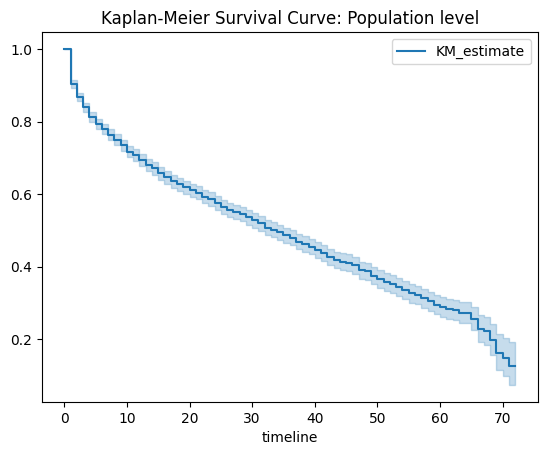

In [83]:
kmf.plot(title='Kaplan-Meier Survival Curve: Population level')

In [84]:
kmf.median_survival_time_

np.float64(34.0)

In [85]:
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
  ax = plt.subplot(111)
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(telco_pd['tenure'], telco_pd[col], telco_pd['churn'])
  return log_rank.summary

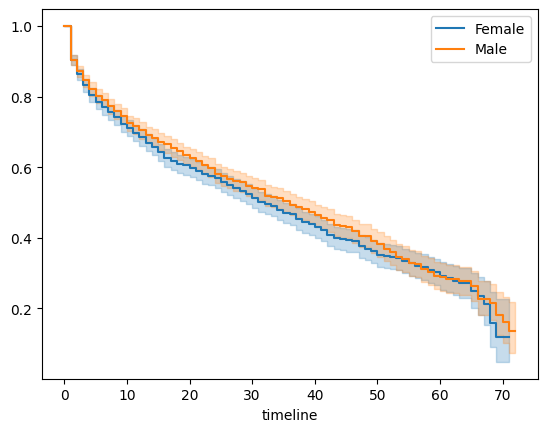

In [86]:
plot_km('gender')

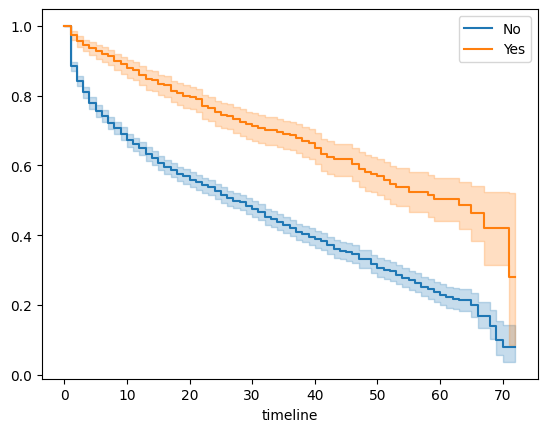

In [87]:
plot_km('onlineSecurity')

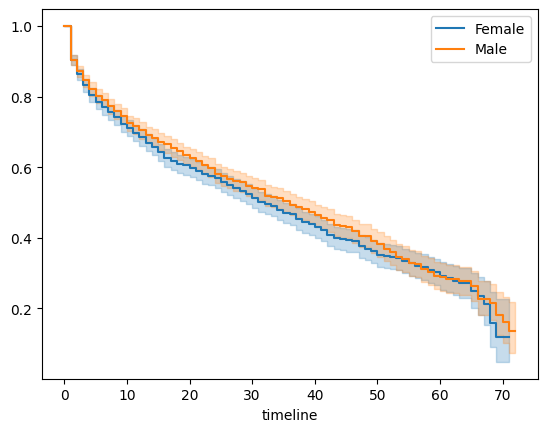

In [88]:
plot_km('gender')

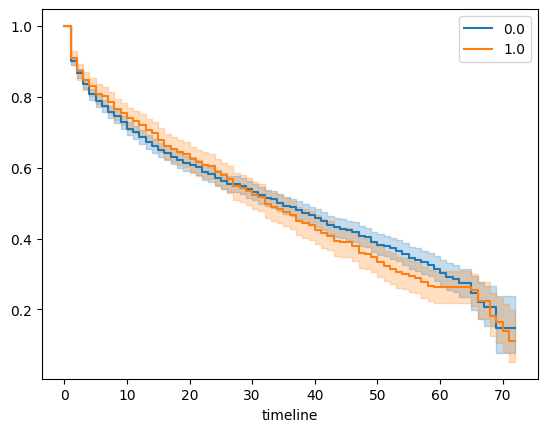

In [89]:
plot_km('seniorCitizen')

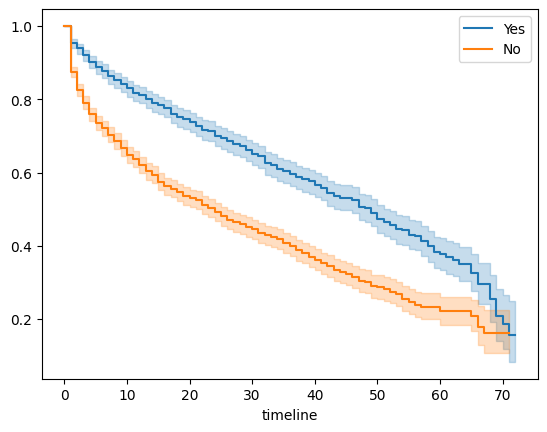

In [90]:
plot_km('partner')

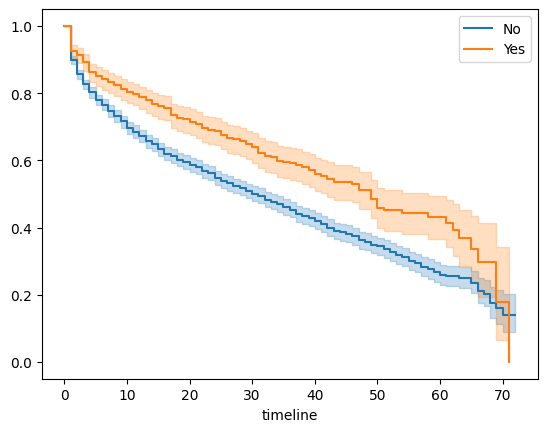

In [91]:
plot_km('dependents')

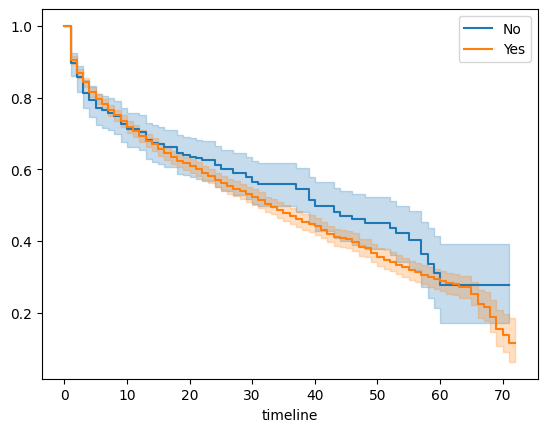

In [92]:
plot_km('phoneService')

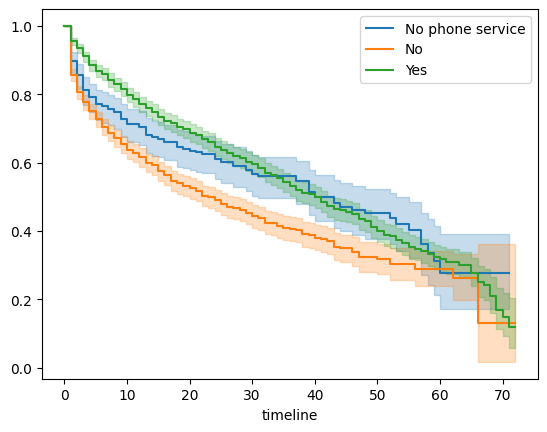

In [93]:
plot_km('multipleLines')

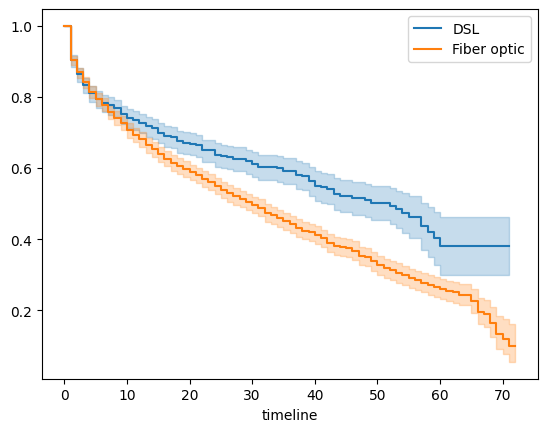

In [94]:
plot_km('internetService')

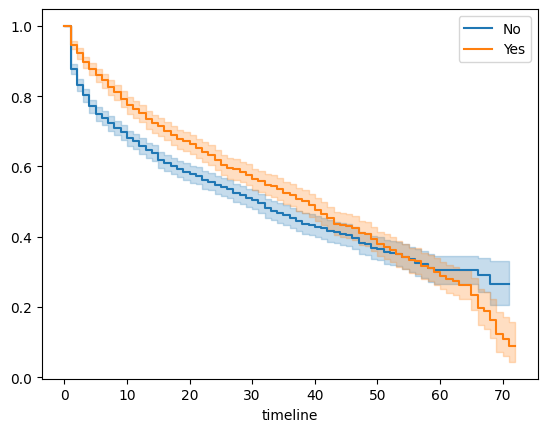

In [95]:
plot_km('streamingTV')

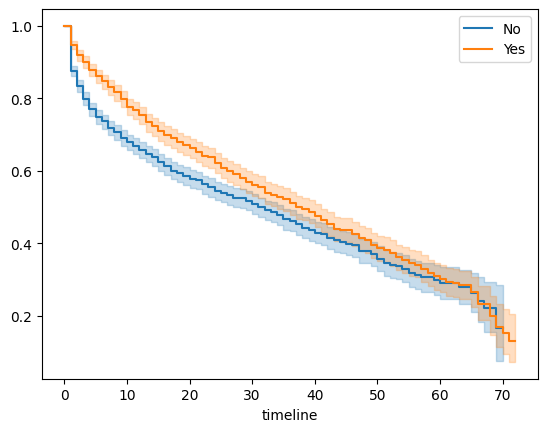

In [96]:
plot_km('streamingMovies')

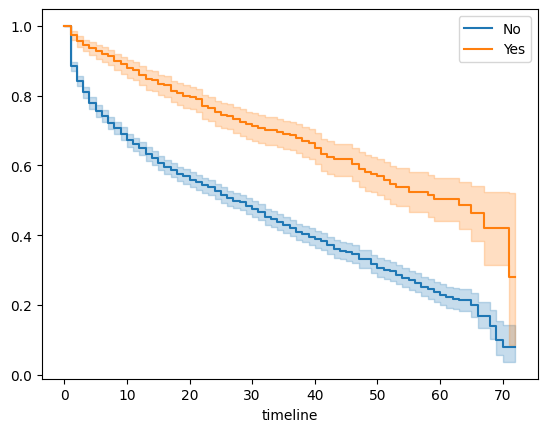

In [97]:
plot_km('onlineSecurity')

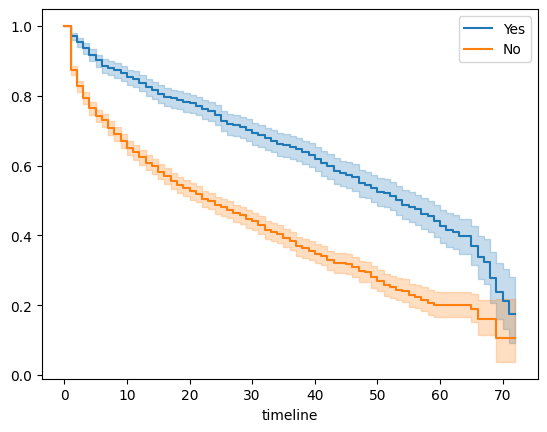

In [98]:
plot_km('onlineBackup')

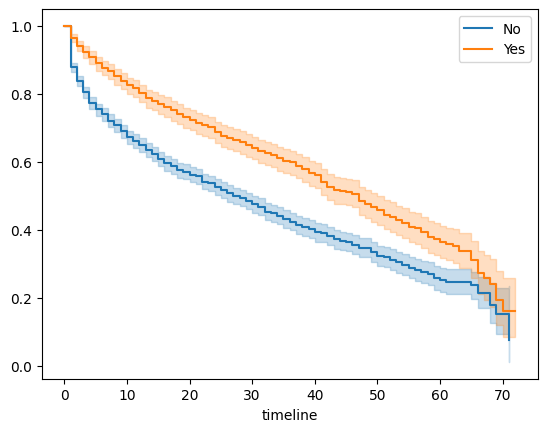

In [99]:
plot_km('deviceProtection')

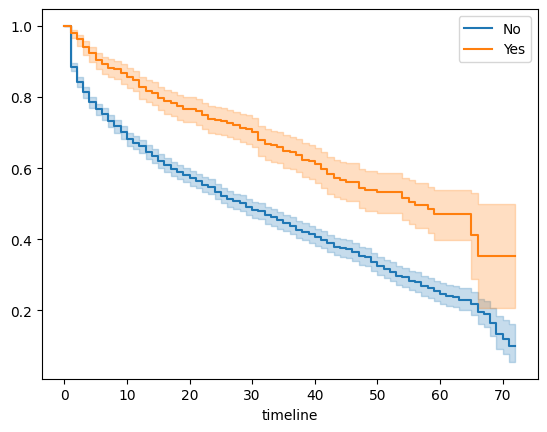

In [100]:
plot_km('techSupport')

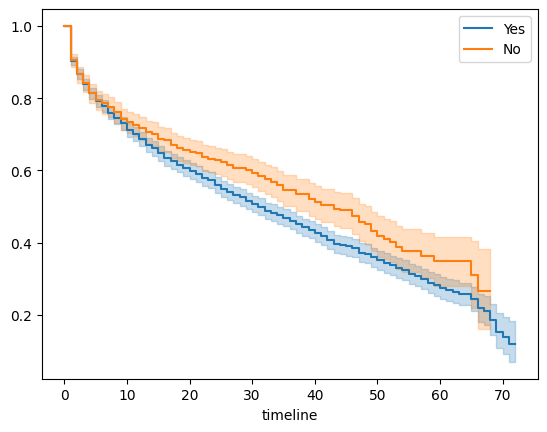

In [101]:
plot_km('paperlessBilling')

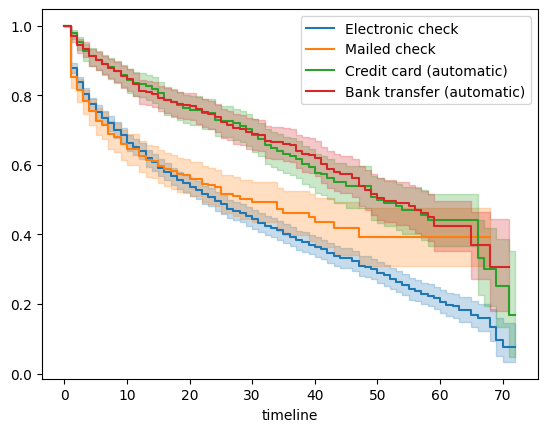

In [102]:
plot_km('paymentMethod')

In [103]:
def get_survival_probs(col,val):
  ix = telco_pd[col] == val
  return kmf.fit(T[ix],C[ix],label=val)  

In [104]:
# Extract survival probabilities for customers with internetService = DSL
sp_internet_dsl = get_survival_probs('internetService','DSL')
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))

,DSL
0,1.000000
1,0.902698
2,0.864380
3,0.834702
4,0.810522
5,0.794352
6,0.783900
7,0.776362
8,0.768486
9,0.750833


## 02

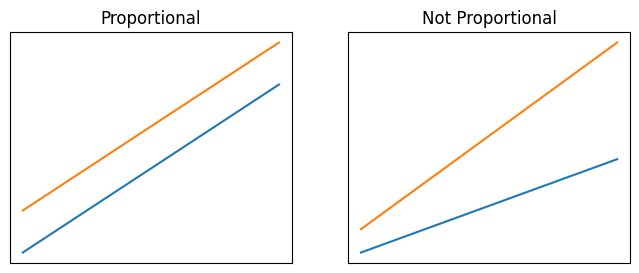

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
 
ax1.plot([1,2,3,4,5],[1,2,3,4,5])
ax1.plot([1,2,3,4,5],[2,3,4,5,6])
ax1.title.set_text('Proportional')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
 
ax2.plot([1,2,3,4,5],[1,2,3,4,5])
ax2.plot([1,2,3,4,5],[2,4,6,8,10])
ax2.title.set_text('Not Proportional')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

In [106]:
import pandas as pd
import seaborn as sns
import numpy as np
 
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [107]:

telco_pd = spark.table('silver_monthly_customers').toPandas()

In [108]:
encode_cols = ['dependents','internetService','onlineBackup','techSupport','paperlessBilling']
 
encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,customerID,gender,seniorCitizen,partner,tenure,phoneService,multipleLines,onlineSecurity,deviceProtection,streamingTV,streamingMovies,contract,paymentMethod,monthlyCharges,totalCharges,churn,dependents_No,dependents_Yes,internetService_DSL,internetService_Fiber optic,onlineBackup_No,onlineBackup_Yes,techSupport_No,techSupport_Yes,paperlessBilling_No,paperlessBilling_Yes
0,7590-VHVEG,Female,0.0,Yes,1.0,No,No phone service,No,No,No,No,Month-to-month,Electronic check,29.85,29.85,0,True,False,True,False,False,True,True,False,False,True
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,Yes,No,No,No,Month-to-month,Mailed check,53.85,108.15,1,True,False,True,False,False,True,True,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,No,No,No,Month-to-month,Electronic check,70.70,151.65,1,True,False,False,True,True,False,True,False,False,True
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Electronic check,99.65,820.50,1,True,False,False,True,True,False,True,False,False,True
4,1452-KIOVK,Male,0.0,No,22.0,Yes,Yes,No,No,Yes,No,Month-to-month,Credit card (automatic),89.10,1949.40,0,False,True,False,True,False,True,True,False,False,True


In [109]:
survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes']]

In [110]:

survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')

In [111]:
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_pd, 'tenure', 'churn')

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>

In [112]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11315.95
         time fit was run = 2025-04-13 12:01:49 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
dependents_Yes      -0.33      0.72      0.07           -0.47           -0.19                0.63                0.83
internetService_DSL -0.22      0.80      0.06           -0.33           -0.10                0.72                0.90
onlineBackup_Yes    -0.78      0.46      0.06           -0.89           -0.66                0.41                0.52
techSupport_Yes     -0.64      0.53      0.08           -0.79           -0.49                0.46                0.61

                     cmp to      z      p  -log2(p)
covariate                                          
dependents_Yes         0.00  -4.64 <0.005     18.12
internetService_DSL    0.00  -3.68 <0.005     12.07
onlineBackup_Yes       0.00 -13.13 <0.005    128.37
techSupport_Yes        0.00  -8.48 <0.005     55.36
---
Concordance = 0.64
Partial AIC = 22639.90
log-likelihood ratio test = 337.77 on 4 df
-log2(p) of ll-ratio test = 236.24

<Axes: xlabel='HR (95% CI)'>

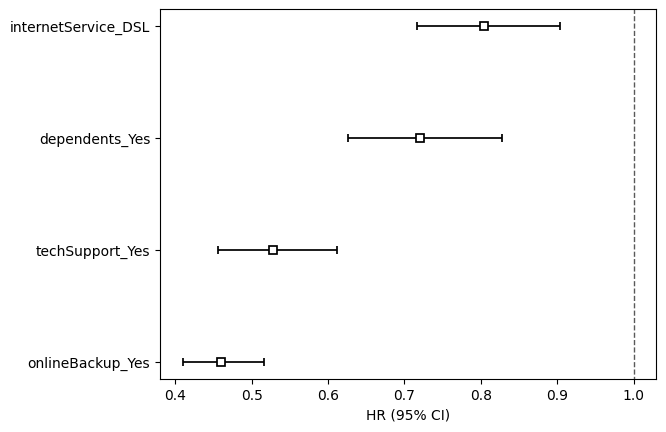

In [113]:
cph.plot(hazard_ratios=True)

In [114]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
dependents_Yes      km              1.48   0.22      2.16
                    rank            0.81   0.37      1.44
internetService_DSL km             20.98 <0.005     17.72
                    rank           26.71 <0.005     22.01
onlineBackup_Yes    km             17.80 <0.005     15.31
                    rank           17.47 <0.005     15.07
techSupport_Yes     km              8.09 <0.005      7.81
                    rank           13.76 <0.005     12.23



1. Variable 'internetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['internetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'onlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['onlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'techSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['techSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://l

[]

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
dependents_Yes      km              1.48   0.22      2.16
                    rank            0.81   0.37      1.44
internetService_DSL km             20.98 <0.005     17.72
                    rank           26.71 <0.005     22.01
onlineBackup_Yes    km             17.80 <0.005     15.31
                    rank           17.47 <0.005     15.07
techSupport_Yes     km              8.09 <0.005      7.81
                    rank           13.76 <0.005     12.23



1. Variable 'internetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['internetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'onlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['onlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'techSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['techSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

[[<Axes: xlabel='rank-transformed time\n(p=0.3680)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2232)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0002)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0044)'>]]

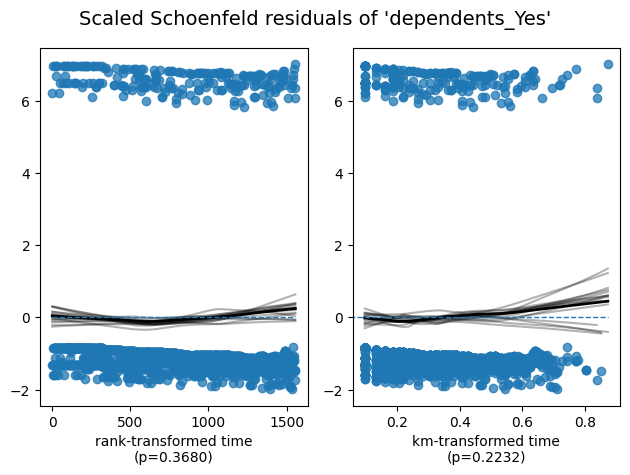

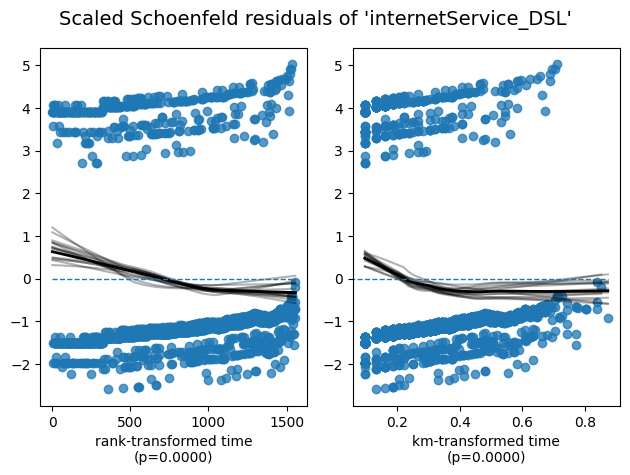

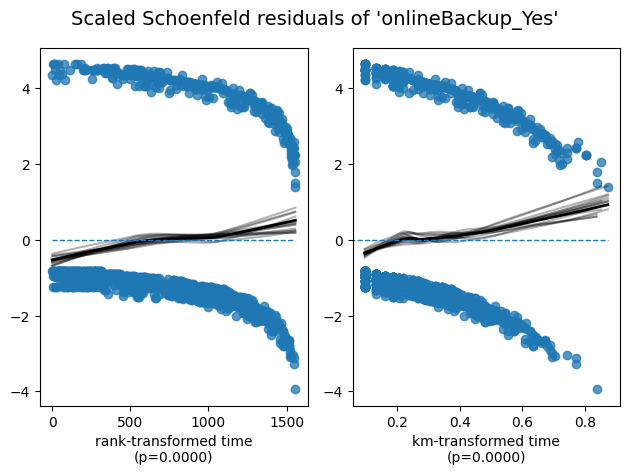

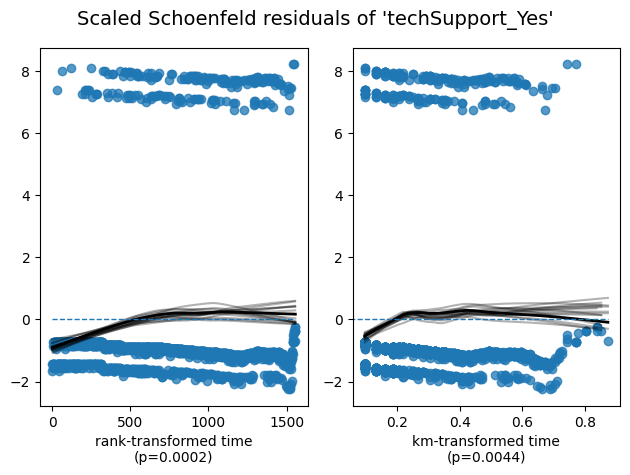

In [115]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05,show_plots=True)

In [116]:
# Fit the Kaplan-Meier model
kmf = KaplanMeierFitter()
 
T=telco_pd['tenure'] #duration
C=telco_pd['churn'].astype(float) #event observed
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

In [117]:
# Utility function for plotting
import matplotlib.pyplot as plt
def plot_km_loglog(col):
  ax = plt.subplot(111)
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot_loglogs(ax=ax)

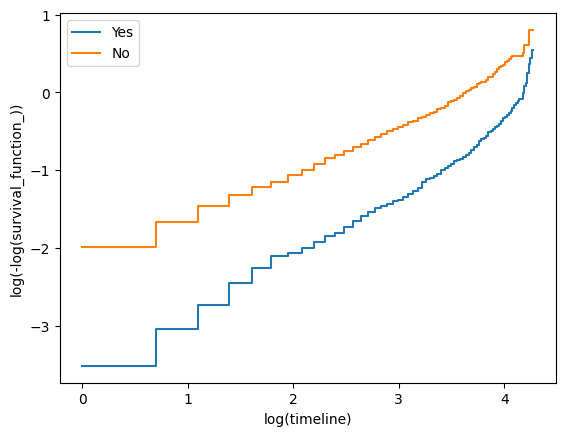

In [118]:
plot_km_loglog('onlineBackup')


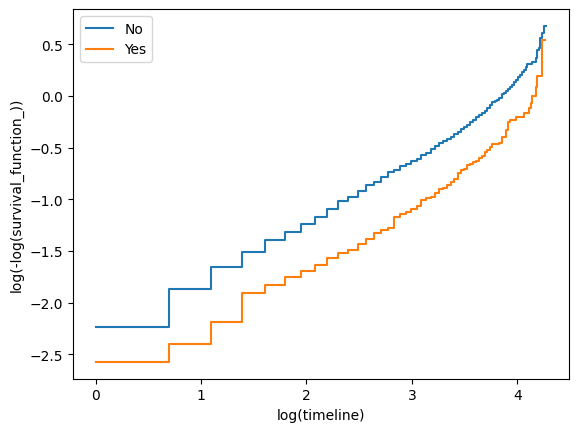

In [119]:
plot_km_loglog('dependents')

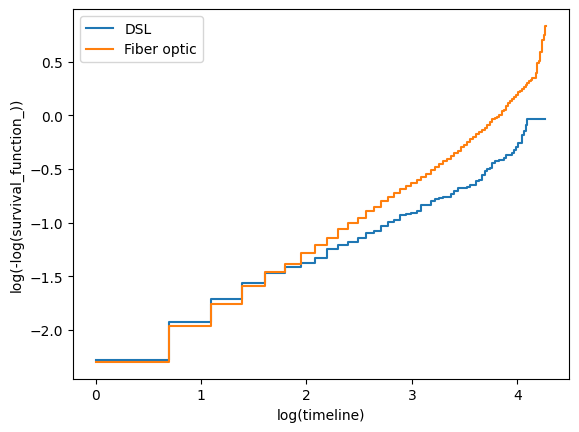

In [120]:

plot_km_loglog('internetService')


In [ ]:

plot_km_loglog('techSupport')

## 04

In [121]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [122]:

telco_pd = spark.table('silver_monthly_customers').toPandas()

In [123]:
encode_cols = ['partner','multipleLines','internetService','onlineSecurity', 'onlineBackup','deviceProtection','techSupport','paymentMethod']
 
encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,customerID,gender,seniorCitizen,dependents,tenure,phoneService,streamingTV,streamingMovies,contract,paperlessBilling,monthlyCharges,totalCharges,churn,partner_No,partner_Yes,multipleLines_No,multipleLines_No phone service,multipleLines_Yes,internetService_DSL,internetService_Fiber optic,onlineSecurity_No,onlineSecurity_Yes,onlineBackup_No,onlineBackup_Yes,deviceProtection_No,deviceProtection_Yes,techSupport_No,techSupport_Yes,paymentMethod_Bank transfer (automatic),paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check
0,7590-VHVEG,Female,0.0,No,1.0,No,No,No,Month-to-month,Yes,29.85,29.85,0,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,False,False,True,False
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,No,Month-to-month,Yes,53.85,108.15,1,True,False,True,False,False,True,False,False,True,False,True,True,False,True,False,False,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,Month-to-month,Yes,70.70,151.65,1,True,False,True,False,False,False,True,True,False,True,False,True,False,True,False,False,False,True,False
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,Yes,Month-to-month,Yes,99.65,820.50,1,True,False,False,False,True,False,True,True,False,True,False,False,True,True,False,False,False,True,False
4,1452-KIOVK,Male,0.0,Yes,22.0,Yes,Yes,No,Month-to-month,Yes,89.10,1949.40,0,True,False,False,False,True,False,True,True,False,False,True,True,False,True,False,False,True,False,False


In [124]:
survival_pd = encoded_pd[['churn','tenure','partner_Yes', 'multipleLines_Yes', \
                          'internetService_DSL','onlineSecurity_Yes','onlineBackup_Yes','deviceProtection_Yes','techSupport_Yes',\
                          'paymentMethod_Bank transfer (automatic)','paymentMethod_Credit card (automatic)' ]]

In [125]:
aft = LogLogisticAFTFitter()
aft.fit(survival_pd, duration_col='tenure', event_col='churn')

<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>

In [126]:

print("Median Survival Time:{:.2f}".format(np.exp(aft.median_survival_time_)))

Median Survival Time:135.51


In [127]:
aft.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 3351
number of events observed = 1556
           log-likelihood = -6838.36
         time fit was run = 2025-04-13 12:02:30 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                                
alpha_ deviceProtection_Yes                     0.48      1.62      0.07            0.35            0.62                1.41                1.86
       internetService_DSL                      0.38      1.47      0.08            0.23            0.53                1.26                1.71
       multipleLines_Yes                        0.66      1.94      0.07            0.53            0.80                1.70                2.22
       onlineBackup_Yes                         0.81      2.25      0.07            0.68            0.95                1.97                2.59
       onlineSecurity_Yes                       0.86      2.37      0.09            0.69            1.03                2.00                2.80
       partner_Yes                              0.68      1.97      0.07            0.55            0.81                1.73                2.24
       paymentMethod_Bank transfer (automatic)  0.74      2.10      0.09            0.56            0.92                1.75                2.51
       paymentMethod_Credit card (automatic)    0.80      2.22      0.10            0.61            0.99                1.84                2.68
       techSupport_Yes                          0.69      1.99      0.09            0.52            0.86                1.68                2.36
       Intercept                                1.59      4.91      0.07            1.46            1.72                4.32                5.58
beta_  Intercept                                0.12      1.13      0.02            0.08            0.16                1.08                1.17

                                                cmp to     z      p  -log2(p)
param  covariate                                                             
alpha_ deviceProtection_Yes                       0.00  6.88 <0.005     37.25
       internetService_DSL                        0.00  4.98 <0.005     20.59
       multipleLines_Yes                          0.00  9.64 <0.005     70.70
       onlineBackup_Yes                           0.00 11.63 <0.005    101.50
       onlineSecurity_Yes                         0.00 10.12 <0.005     77.60
       partner_Yes                                0.00 10.21 <0.005     78.93
       paymentMethod_Bank transfer (automatic)    0.00  8.05 <0.005     50.07
       paymentMethod_Credit card (automatic)      0.00  8.36 <0.005     53.81
       techSupport_Yes                            0.00  7.90 <0.005     48.37
       Intercept                                  0.00 24.47 <0.005    436.88
beta_  Intercept                                  0.00  5.71 <0.005     26.42
---
Concordance = 0.73
AIC = 13698.72
log-likelihood ratio test = 877.49 on 9 df
-log2(p) of ll-ratio test = 605.78

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

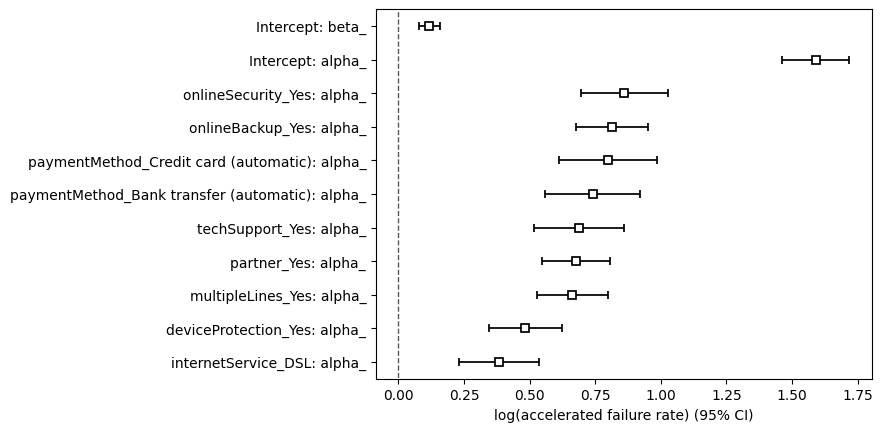

In [128]:
aft.plot()

In [129]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
 
T=telco_pd['tenure'] #duration
C=telco_pd['churn'].astype(float) #event observed
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

In [130]:
import matplotlib.pyplot as plt
 
def plot_km_logOdds(col):
  ax = plt.subplot(111)
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    sf = kmf.survival_function_
    sf['failureOdds'] = (np.log(1-sf))/sf
    sf['logTime'] = np.log(sf.index)
    plt.plot(sf['logTime'],sf['failureOdds'])

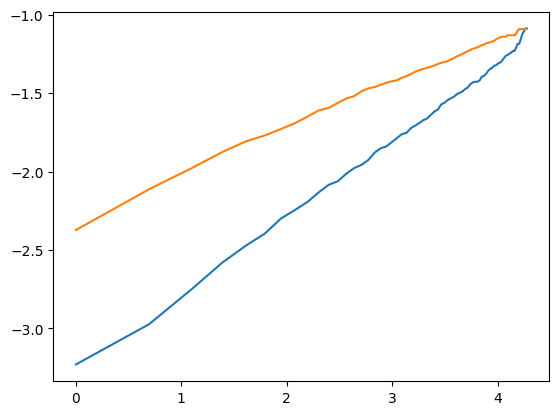

In [131]:
plot_km_logOdds('partner')

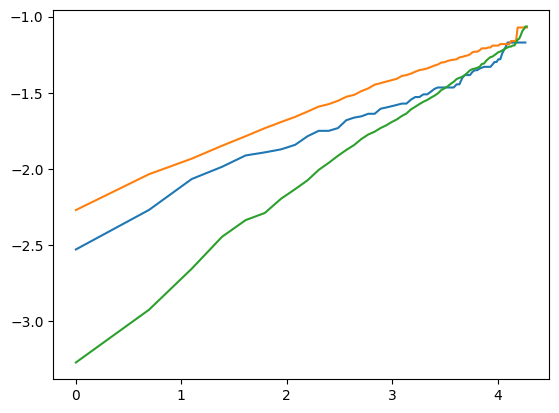

In [132]:
plot_km_logOdds('multipleLines')

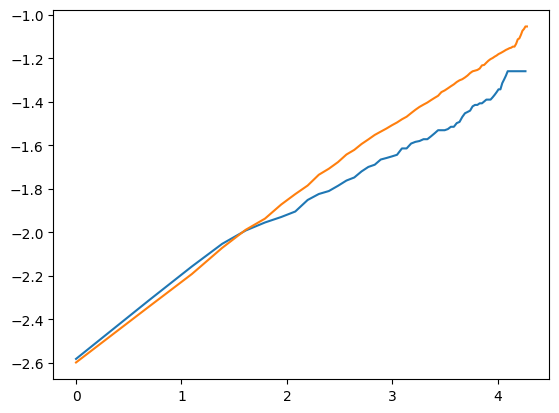

In [133]:
plot_km_logOdds('internetService')

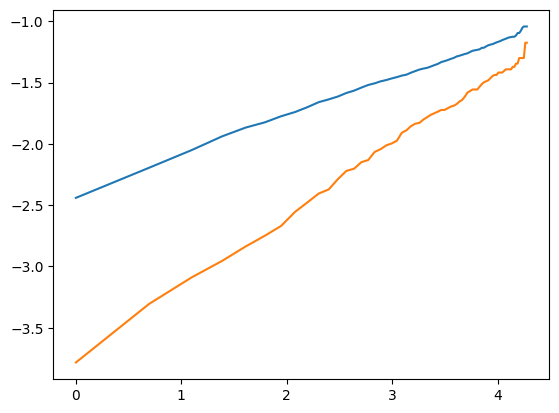

In [134]:
plot_km_logOdds('onlineSecurity')

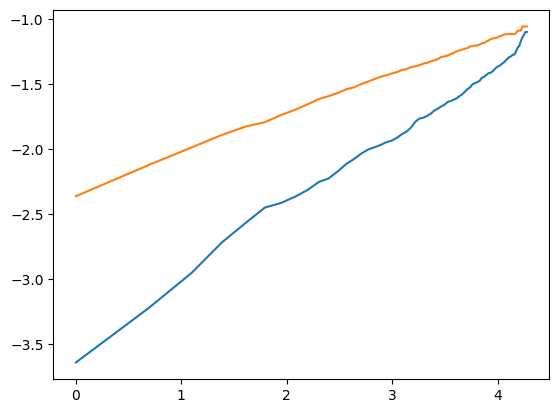

In [135]:
plot_km_logOdds('onlineBackup')

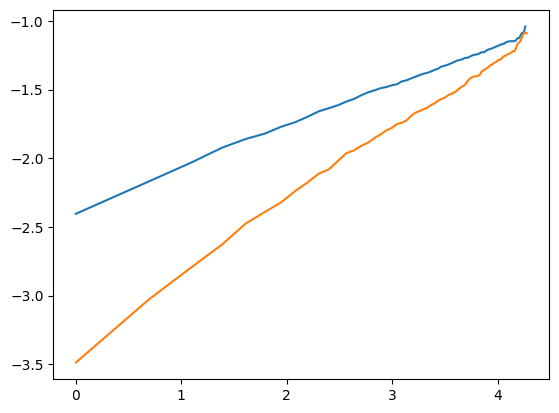

In [136]:
plot_km_logOdds('deviceProtection')

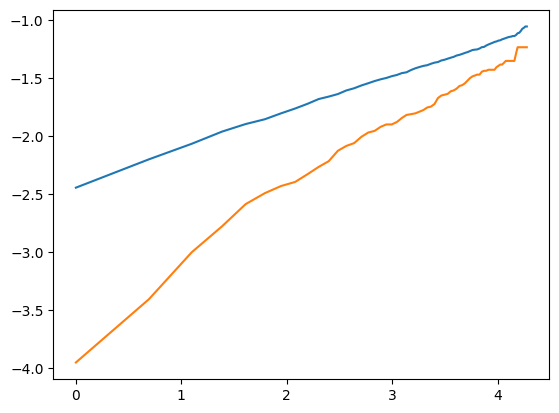

In [137]:
plot_km_logOdds('techSupport')

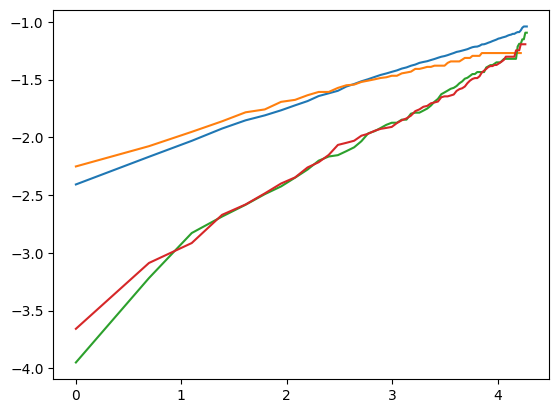

In [138]:
plot_km_logOdds('paymentMethod')

# 05

In [139]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [140]:

telco_pd = spark.table('silver_monthly_customers').toPandas()

In [141]:
encode_cols = ['dependents','internetService','onlineBackup','techSupport','paperlessBilling']
 
encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,customerID,gender,seniorCitizen,partner,tenure,phoneService,multipleLines,onlineSecurity,deviceProtection,streamingTV,streamingMovies,contract,paymentMethod,monthlyCharges,totalCharges,churn,dependents_No,dependents_Yes,internetService_DSL,internetService_Fiber optic,onlineBackup_No,onlineBackup_Yes,techSupport_No,techSupport_Yes,paperlessBilling_No,paperlessBilling_Yes
0,7590-VHVEG,Female,0.0,Yes,1.0,No,No phone service,No,No,No,No,Month-to-month,Electronic check,29.85,29.85,0,True,False,True,False,False,True,True,False,False,True
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,Yes,No,No,No,Month-to-month,Mailed check,53.85,108.15,1,True,False,True,False,False,True,True,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,No,No,No,Month-to-month,Electronic check,70.70,151.65,1,True,False,False,True,True,False,True,False,False,True
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Electronic check,99.65,820.50,1,True,False,False,True,True,False,True,False,False,True
4,1452-KIOVK,Male,0.0,No,22.0,Yes,Yes,No,No,Yes,No,Month-to-month,Credit card (automatic),89.10,1949.40,0,False,True,False,True,False,True,True,False,False,True


In [142]:

survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes']]

In [143]:

survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')

In [144]:
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_pd, 'tenure', 'churn')

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>

In [151]:
cols = ['dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes','partner_Yes',' internal rate of return']

# Mock dbutils for environments outside Databricks
class MockDBUtils:
    class Widgets:
        _widgets = {}

        @staticmethod
        def removeAll():
            print("Mock: Removed all widgets")
            MockDBUtils.Widgets._widgets.clear()

        @staticmethod
        def text(name, defaultValue):
            print(f"Mock: Created text widget '{name}' with default value '{defaultValue}'")
            MockDBUtils.Widgets._widgets[name] = defaultValue

        @staticmethod
        def dropdown(name, choices, defaultValue):
            print(f"Mock: Created dropdown widget '{name}' with choices {choices} and default value '{defaultValue}'")
            MockDBUtils.Widgets._widgets[name] = defaultValue

        @staticmethod
        def get(name):
            return MockDBUtils.Widgets._widgets.get(name, None)

    widgets = Widgets()

dbutils = MockDBUtils()

dbutils.widgets.removeAll()

for col in cols:
  if col == ' internal rate of return':
    dbutils.widgets.text(' internal rate of return', defaultValue='0.10')
  else:
    dbutils.widgets.dropdown(col, choices=['0', '1'], defaultValue='0')

Mock: Removed all widgets
Mock: Created dropdown widget 'dependents_Yes' with choices ['0', '1'] and default value '0'
Mock: Created dropdown widget 'internetService_DSL' with choices ['0', '1'] and default value '0'
Mock: Created dropdown widget 'onlineBackup_Yes' with choices ['0', '1'] and default value '0'
Mock: Created dropdown widget 'techSupport_Yes' with choices ['0', '1'] and default value '0'
Mock: Created dropdown widget 'partner_Yes' with choices ['0', '1'] and default value '0'
Mock: Created text widget ' internal rate of return' with default value '0.10'


In [149]:
# Construct dataframe with values from widgets
def get_widget_values():
  widget_dict = {col:dbutils.widgets.get(col) for col in cols}
  return pd.DataFrame.from_dict(widget_dict,orient='index').T
 
def get_payback_df():
  df = get_widget_values()
  irr = df[' internal rate of return'].astype('float64')[0]/12
  cohort_df = pd.concat([pd.DataFrame([1.00]),round(cph.predict_survival_function(df),2)]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 30
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')


In [152]:
pd.options.display.max_rows = 25
get_payback_df()[0:25]

,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
1,1.00,30,30.0,30.00,30.00
2,0.87,30,26.1,25.88,55.88
3,0.81,30,24.3,23.90,79.78
4,0.77,30,23.1,22.53,102.31
5,0.74,30,22.2,21.48,123.79
6,0.71,30,21.3,20.43,144.22
7,0.69,30,20.7,19.69,163.91
8,0.67,30,20.1,18.97,182.88
9,0.65,30,19.5,18.25,201.13


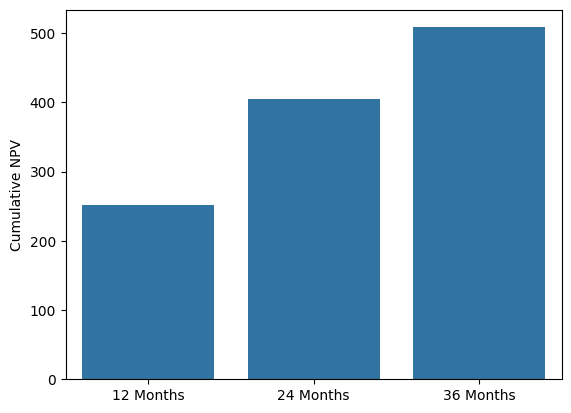

In [154]:
import seaborn as sns

# Example corrected code
ax = sns.barplot(
    x=['12 Months', '24 Months', '36 Months'],  # x-axis values
    y=get_payback_df().iloc[[11, 23, 35], :]['Cumulative NPV']  # y-axis values
)

<Axes: xlabel='Contract Month', ylabel='Survival Probability'>

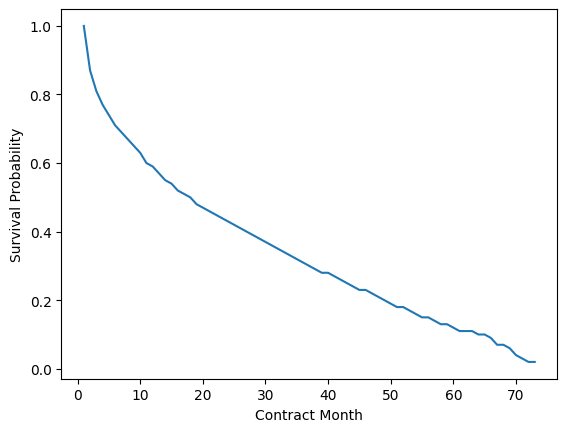

In [156]:
sns.lineplot(x=get_payback_df().index, y=get_payback_df()['Survival Probability'])